In [4]:
import os
import json
import boto3
from tqdm import tqdm

def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('data_subset', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

download_and_arrange_data()

  0%|          | 1/1228 [00:00<02:24,  8.48it/s]

  0%|          | 1/2299 [00:00<06:47,  5.63it/s]

  0%|          | 2/2666 [00:00<03:34, 12.40it/s]

  0%|          | 2/2373 [00:00<03:11, 12.36it/s]

  0%|          | 1/1875 [00:00<03:12,  9.72it/s]

100%|██████████| 1875/1875 [03:17<00:00,  9.51it/s]


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


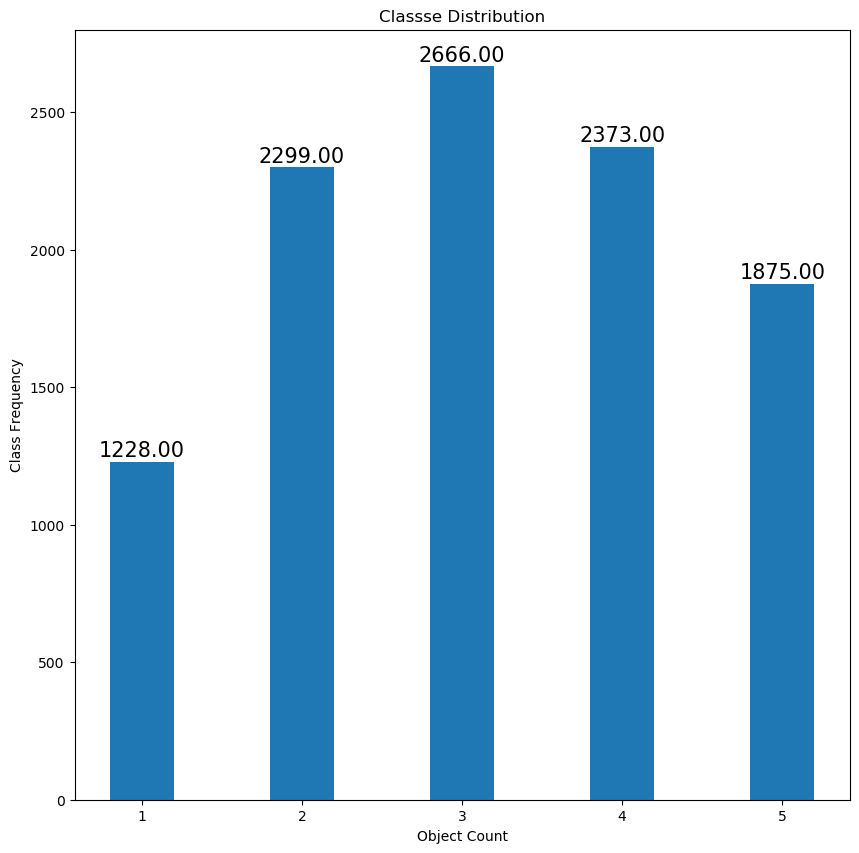

In [89]:
import numpy as np
import matplotlib.pyplot as plt

with open('file_list.json', 'r') as f:
        d=json.load(f)
        
num_objects = [(k) for k in d.keys()]
values = [len(v) for v in d.values()]
  
fig, ax =  plt.subplots(figsize = (10, 10))
 
# creating the bar plot
ax.bar(num_objects, values, width = 0.4)

# Iterrating over the bars one-by-one
for bar in ax.patches:
   
    ax.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
 
 
plt.xlabel("Object Count")
plt.ylabel("Class Frequency")
plt.title("Classse Distribution")
plt.show()

In [91]:
# Perform data exploration
local_data_path = "data"

main_dirs = os.listdir(local_data_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(local_data_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items in it.')

There are 1228 images with 1 items in it.
There are 2299 images with 2 items in it.
There are 2666 images with 3 items in it.
There are 2373 images with 4 items in it.
There are 1875 images with 5 items in it.


<Figure size 800x800 with 0 Axes>

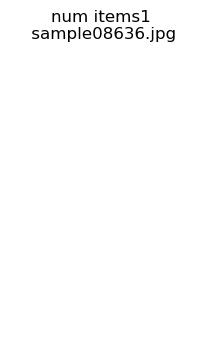

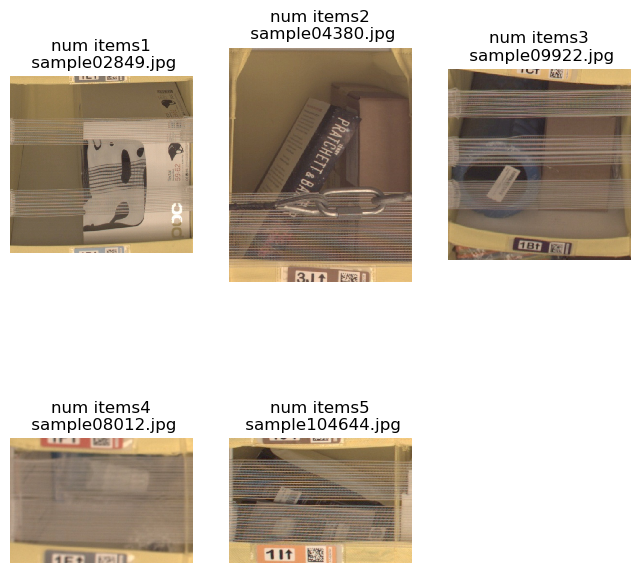

In [ ]:
import matplotlib.image as mpimg

# Data visualzation
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
# visulize file to understand  our data
for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample" + img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(local_data_path, key, img_filename)).squeeze(), cmap="gray")
    
plt.show()
figure.savefig('sample_dataset.png')

In [ ]:
# Data Preprocessing

In [9]:
!pip install smdebug torch torchvision tqdm

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)


In [10]:
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [11]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import IPython

[2023-06-01 01:17:56.573 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [17]:
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [18]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [19]:
import sagemaker
from sagemaker.pytorch import PyTorch
hyperparameters = {"batch_size": 64, 
                   "epochs": "5"}

role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    framework_version='1.8',
    py_version='py36',
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    hyperparameters = hyperparameters
)

In [20]:
os.environ['SM_CHANNEL_TRAINING']='s3://yasproject3/data/'
os.environ['SM_MODEL_DIR']='s3://yasproject3/model/'
os.environ['SM_OUTPUT_DATA_DIR']='s3://yasproject3/output/'

In [21]:
estimator.fit({"training": "s3://yasproject3/data/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framewo

2023-06-01 01:23:55 Starting - Starting the training job...
2023-06-01 01:24:24 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-06-01 01:25:24 Downloading - Downloading input data...
2023-06-01 01:26:05 Training - Downloading the training image........................
2023-06-01 01:30:06 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-01 01:29:53,411 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-01 01:29:53,440 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-01 01:29:53,443 sagemaker_pytorch_container.training INFO     Invoking user training s

In [24]:
estimator.fit({"training": "s3://yasproject3/data/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-06-01-01-33-23-860


2023-06-01 01:33:26 Starting - Starting the training job...
2023-06-01 01:33:55 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-06-01 01:34:56 Downloading - Downloading input data...
2023-06-01 01:35:22 Training - Downloading the training image.....................
2023-06-01 01:38:58 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-01 01:39:02,910 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-01 01:39:02,942 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-01 01:39:02,946 sagemaker_pytorch_container.training INFO     Invoking user training scr

In [32]:
import sagemaker
from sagemaker.pytorch import PyTorch
hyperparameters = {"batch_size": 16, 
                   "epochs": "25"}

role = sagemaker.get_execution_role()

estimator = PyTorch(
    entry_point='train.py',
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    framework_version='1.8',
    py_version='py36',
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
    hyperparameters = hyperparameters
)

In [33]:
estimator.fit({"training": "s3://yasproject3/data/"}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-06-01-01-51-51-484


2023-06-01 01:51:53 Starting - Starting the training job...
2023-06-01 01:52:24 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-06-01 01:53:25 Downloading - Downloading input data...
2023-06-01 01:53:58 Training - Downloading the training image..................
2023-06-01 01:57:02 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-06-01 01:57:13,726 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-06-01 01:57:13,755 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-06-01 01:57:13,759 sagemaker_pytorch_container.training INFO     Invoking user training scrip

In [37]:
# Update conda Flask Jinja2 & MarkupSafe templating language for AWS Python ecosystem
! conda update Flask Jinja2 MarkupSafe --yes -q

Solving environment: ...working... done

# All requested packages already installed.

Retrieving notices: ...working... done


In [43]:
! pip install Flask==2.0.3

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [44]:
# Installing jinja2 v3.0 Werkzeug v2.0.0 
! pip -q install jinja2==3.0.1 Werkzeug==2.0.0

Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [50]:
!pip install --upgrade markupsafe


Keyring is skipped due to an exception: 'keyring.backends'

[notice] A new release of pip available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [57]:
!pip install jinja2==3.0.3 --force-reinstall


Keyring is skipped due to an exception: 'keyring.backends'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.6/133.6 kB 1.8 MB/s eta 0:00:0000:01
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.1.2
    Uninstalling MarkupSafe-2.1.2:
      Successfully uninstalled MarkupSafe-2.1.2
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 3.1.2
    Uninstalling Jinja2-3.1.2:
      Successfully uninstalled Jinja2-3.1.2

[notice] A new release of pip available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [58]:
from markupsafe import Markup

In [59]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts


ImportError: cannot import name 'Markup' from 'jinja2' (/opt/conda/lib/python3.7/site-packages/jinja2/__init__.py)

In [22]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())


tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

Training jobname: pytorch-training-2023-06-01-01-23-53-159
Region: us-east-1
[2023-06-01 01:31:52.319 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-352782712576/pytorch-training-2023-06-01-01-23-53-159/debug-output


NameError: name 'TrainingJob' is not defined

In [ ]:
trial = create_trial(debug_artifacts_path)
print("No of TRAIN datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))))
print("No of EVAL datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))))

In [ ]:
# Creating Cross Entropy Loss as metric or view from AWS Cloudwatch 
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded train data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded evaluation data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (train)")
    par.set_xlabel("Steps (eval)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed train plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed eval plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show();
    fig.savefig('training_values.png')

In [ ]:
plot_tensor(trial, "CrossEntropyLoss_output_0")
